In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import seaborn as sns
from scipy.sparse import vstack, hstack, csr_matrix, save_npz, load_npz
sns.set()
import gc

from utils.schemas import *
from utils.functions import *

In [2]:
df_imp = pd.read_csv('docs/ft_importances_20190811.csv')

In [4]:
df_imp.head(10)

,feature,importance
0,TransactionAmt,3.000000
1,card1,2.204488
2,C13,2.070567
3,N1,1.881225
4,C1,1.691782
5,card2,1.664059
6,addr1,1.501876
7,N3,1.417283
8,D15,1.384750
9,C14,1.305814


In [3]:
X_cols = df_imp[df_imp.importance > 0.1].feature.to_list()
# X_cols = df_imp.feature[:75].to_list()

In [5]:
data_folder = 'input'

In [6]:
train = pd.read_csv(data_folder+'/train_ft_eng_0.csv', dtype = schema_generated_0, usecols=X_cols+['isFraud', 'TransactionDT']).sort_values('TransactionDT')
test = pd.read_csv(data_folder+'/test_ft_eng_0.csv', dtype = schema_generated_0, usecols=X_cols+['TransactionDT']).sort_values('TransactionDT')

In [7]:
train.shape

(590540, 245)

In [8]:
train.head()

,C1,C10,C11,C12,C13,C14,C2,C4,C5,C6,...,N2,N3,N4,group_2_n_4,group_2_n_8,group_2_n_16,group_1_n_32,group_2_n_32,group_1_n_64,group_2_n_64
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,43034,327.0,141694,3,5,6,0,16,0,49
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,76899,14609.0,328620,0,3,0,0,18,0,25
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,48384,77435.0,5123,0,3,0,0,18,0,25
3,2.0,0.0,1.0,0.0,25.0,1.0,5.0,0.0,0.0,4.0,...,17453,6.0,163824,0,3,0,22,0,33,17
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,7107,8000.0,328620,3,4,2,0,15,0,45


In [9]:
test.head()

,C1,C10,C11,C12,C13,C14,C2,C4,C5,C6,...,N2,N3,N4,group_2_n_4,group_2_n_8,group_2_n_16,group_1_n_32,group_2_n_32,group_1_n_64,group_2_n_64
0,6.0,0.0,5.0,1.0,115.0,6.0,6.0,0.0,3.0,4.0,...,3810,1.0,328620,0,0,9,24,20,63,20
1,3.0,0.0,1.0,1.0,12.0,2.0,2.0,0.0,0.0,1.0,...,85019,4.0,45196,0,3,0,0,18,58,0
2,2.0,0.0,2.0,0.0,22.0,2.0,2.0,0.0,0.0,5.0,...,15704,2.0,32600,3,5,3,22,17,58,42
3,5.0,0.0,2.0,0.0,7.0,4.0,2.0,0.0,1.0,1.0,...,11025,5.0,328620,0,3,0,0,18,61,0
4,6.0,0.0,6.0,0.0,14.0,6.0,6.0,0.0,2.0,5.0,...,72580,1.0,328620,0,3,0,22,18,58,0


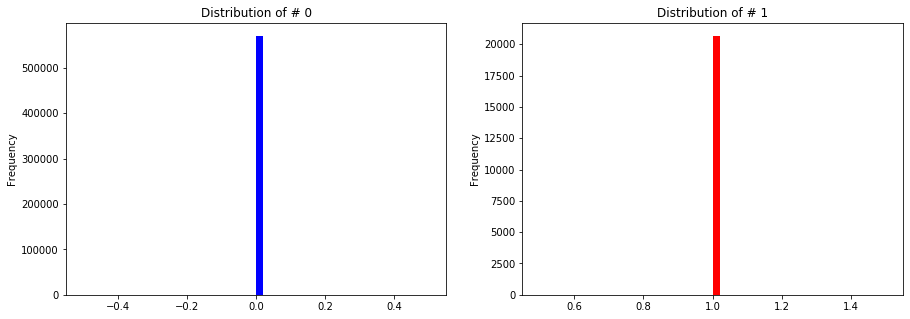

In [9]:
f,ax=plt.subplots(1,2,figsize=(15,5))
train[train.isFraud == 0].isFraud.plot.hist(ax=ax[0], color = 'blue', bins=50)
ax[0].set_title('Distribution of # 0')
train[train.isFraud == 1].isFraud.plot.hist(ax=ax[1], color = 'red', bins=50)
ax[1].set_title('Distribution of # 1')
plt.show()

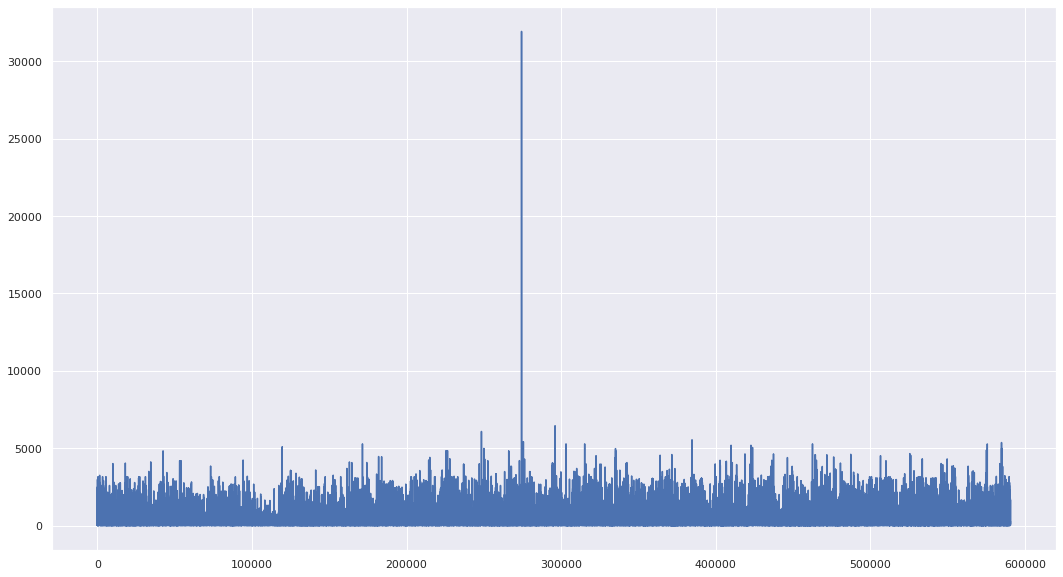

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
ax.plot(list(range(train.TransactionAmt.shape[0])), train.TransactionAmt)
plt.show()

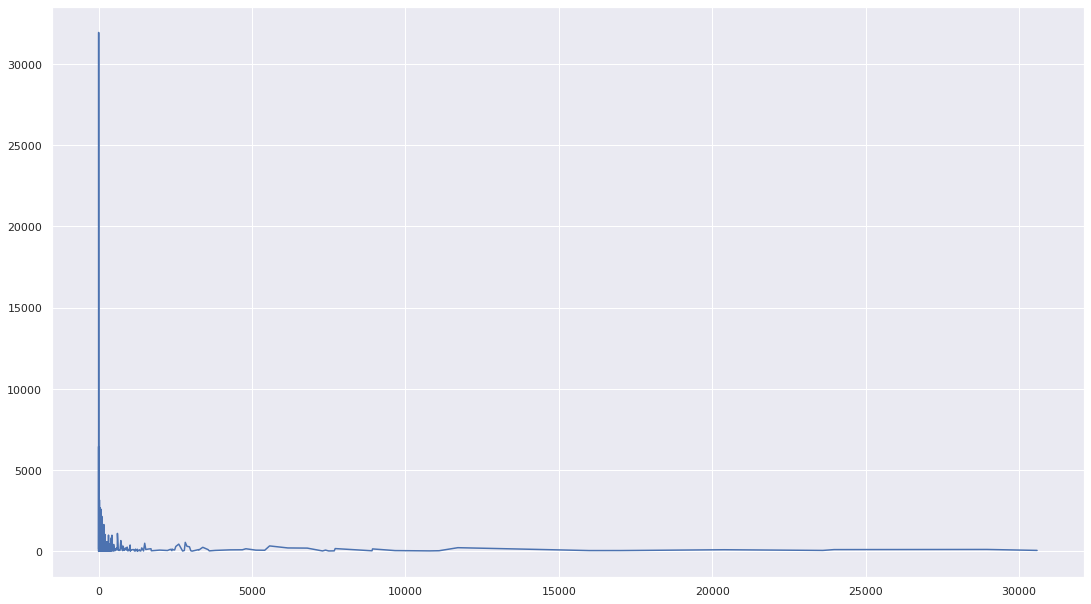

In [32]:
train.TransactionAmt.value_counts()

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train.TransactionAmt.value_counts(), train.TransactionAmt.value_counts().index.to_list())
plt.show()

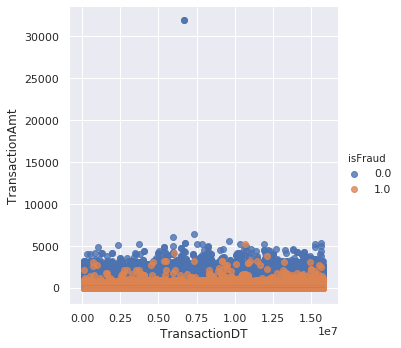

In [34]:
# Ver si utilizando el std o la media en TransactionAmt aumenta el target
g = sns.lmplot(x="TransactionDT", y="TransactionAmt", hue="isFraud",
               truncate=True, height=5, data=train[['TransactionDT', 'TransactionAmt', 'isFraud']])


In [42]:
card_tran = train.groupby(['card1', 'TransactionAmt']).count()

In [45]:
group1 = card_tran['TransactionDT']
group1.name = 'card_count_transaction'
train2 = train.join(group1, on=['card1', 'TransactionAmt'])

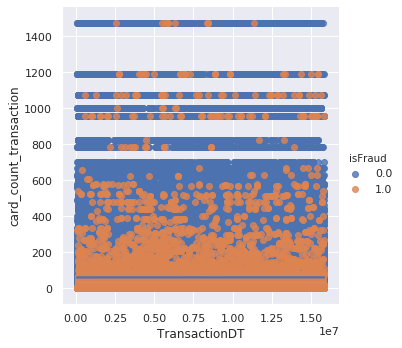

In [47]:
g = sns.lmplot(x="TransactionDT", y="card_count_transaction", hue="isFraud",
               truncate=True, height=5, data=train2[['TransactionDT', 'card_count_transaction', 'isFraud']])

In [9]:
train['trans_dif'] = train['TransactionAmt'] - train['TransactionAmt'].apply(lambda x: int(x))

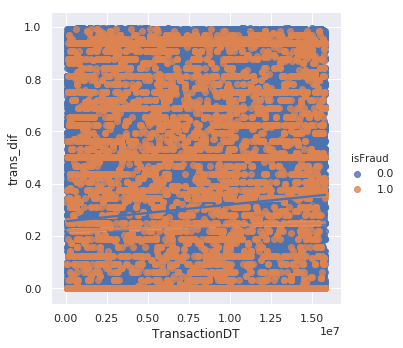

In [13]:
g = sns.lmplot(x="TransactionDT", y="trans_dif", hue="isFraud",
               truncate=True, height=5, data=train)

In [51]:
d = train.std(axis = 0, skipna = True)['TransactionAmt']
m = np.mean(train['TransactionAmt'].values)
train['des_amt'] = train['TransactionAmt'].apply(lambda x: (x-d)/m)

In [52]:
m, d

(135.0, 239.15743790426998)

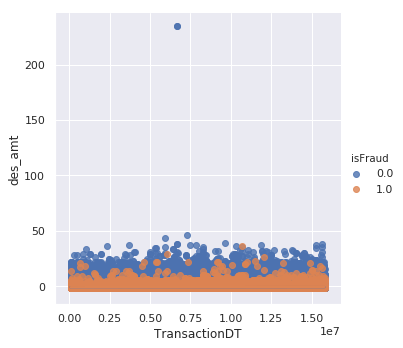

In [53]:
g = sns.lmplot(x="TransactionDT", y="des_amt", hue="isFraud",
               truncate=True, height=5, data=train)

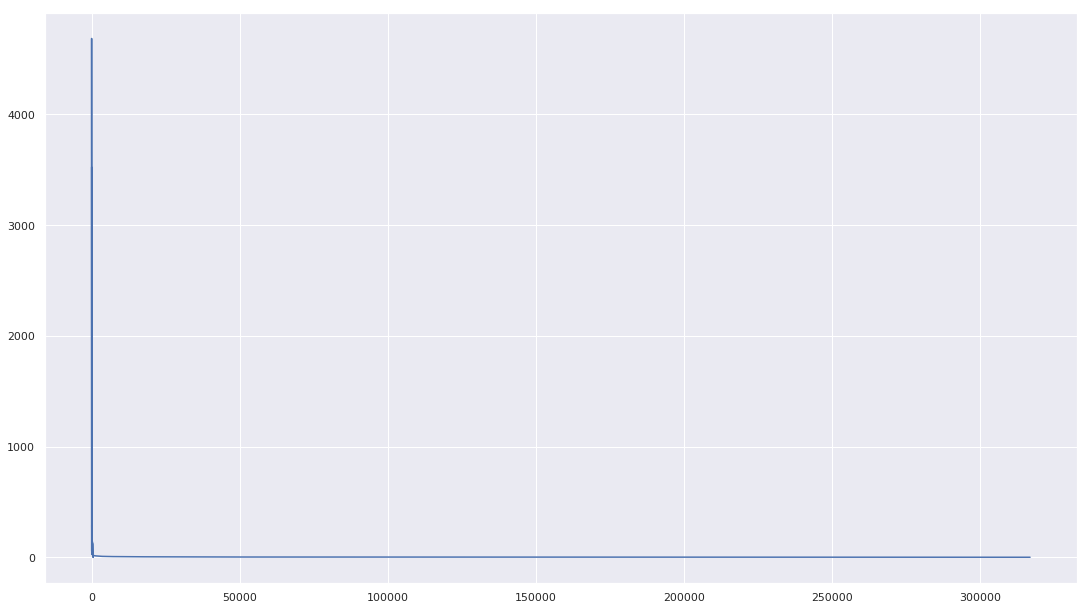

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train.C1.value_counts(), train.C1.value_counts().index.to_list())
plt.show()

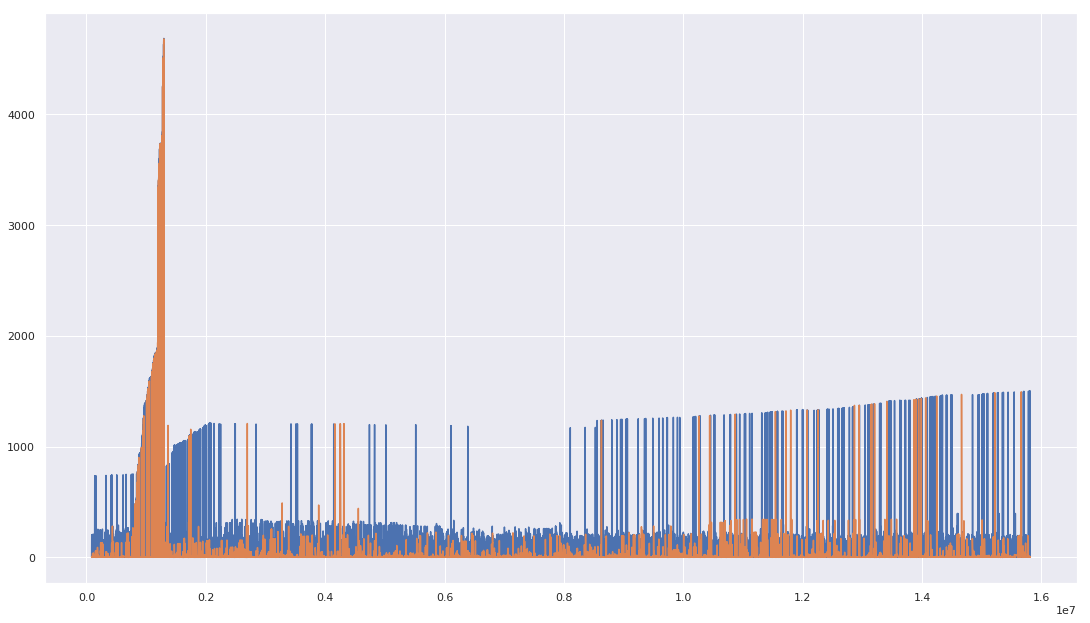

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].C1)
ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].C1)
plt.show()

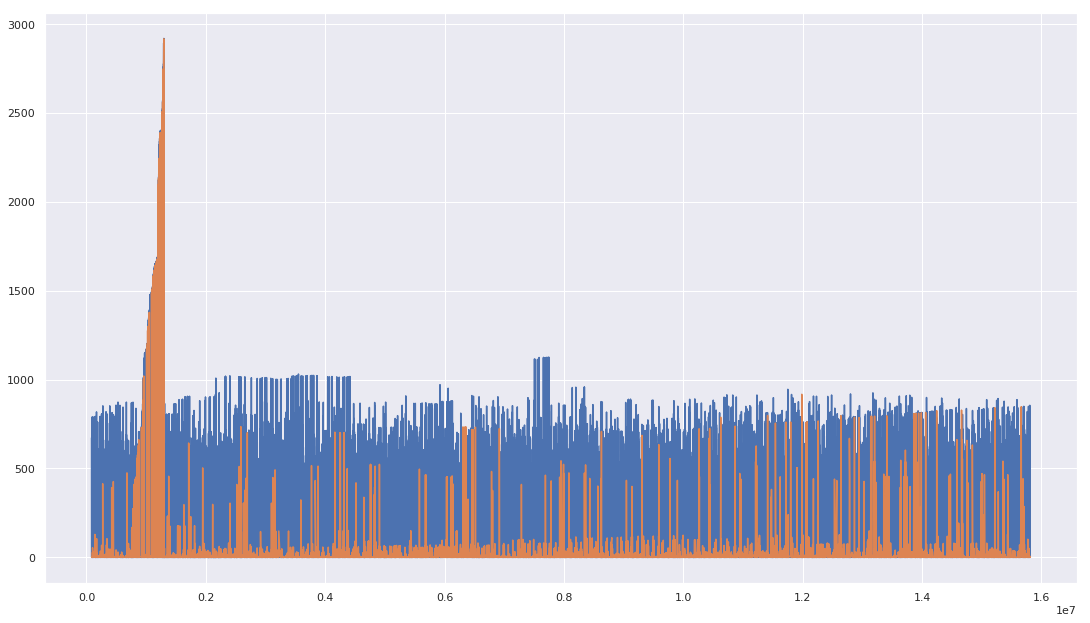

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].C13)
ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].C13)
plt.show()

In [70]:
X_cols

['TransactionAmt',
 'card1',
 'C13',
 'N1',
 'C1',
 'card2',
 'addr1',
 'N3',
 'D15',
 'C14',
 'Transaction_hour',
 'C11',
 'card1_fe1',
 'addr1_fe1',
 'N2',
 'D1',
 'card2_fe1',
 'group_2_n_64',
 'C6',
 'dist1',
 'D2',
 'D4',
 'Transaction_day_of_week',
 'addr1_fe2',
 'C2',
 'D10',
 'V258',
 'N4',
 'group_2_n_32',
 'card2_fe2',
 'P_emaildomain',
 'V307',
 'id_02',
 'card5',
 'card1_fe2',
 'DeviceInfo',
 'P_emaildomain_0',
 'V45',
 'V310',
 'C12',
 'P_emaildomain_fe2',
 'D11',
 'M5',
 'D3',
 'V317',
 'M6',
 'C9',
 'D8',
 'V308',
 'V201',
 'group_2_n_16',
 'card6',
 'id_19',
 'P_emaildomain_0_fe1',
 'card5_fe1',
 'V313',
 'id_31',
 'P_emaildomain_0_fe2',
 'V257',
 'C4',
 'D5',
 'C7',
 'V200',
 'V283',
 'M6_fe2',
 'C8',
 'id_20',
 'card5_fe2',
 'P_emaildomain_fe1',
 'C10',
 'V87',
 'V281',
 'V243',
 'V312',
 'V294',
 'V189',
 'V246',
 'M4',
 'M5_fe1',
 'V187',
 'V315',
 'V314',
 'V244',
 'V44',
 'V127',
 'card6_fe1',
 'id_01',
 'id_13',
 'group_1_n_64',
 'V54',
 'V53',
 'V62',
 'R_emaild

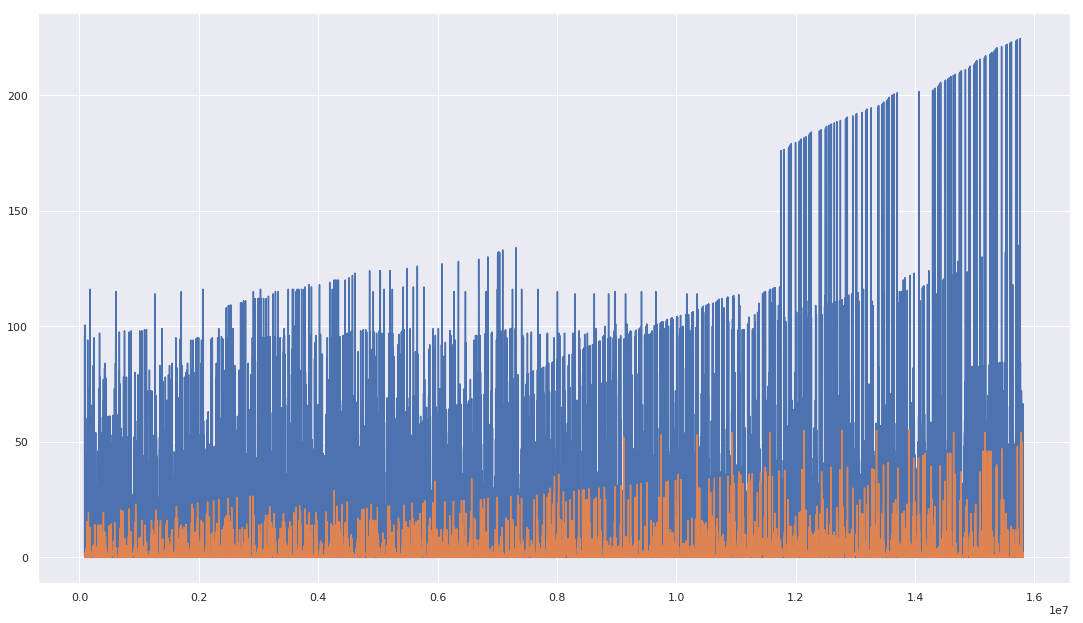

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].C13/
       train[train.isFraud == 0].C1)
ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].C13/
       train[train.isFraud == 1].C1)
plt.show()

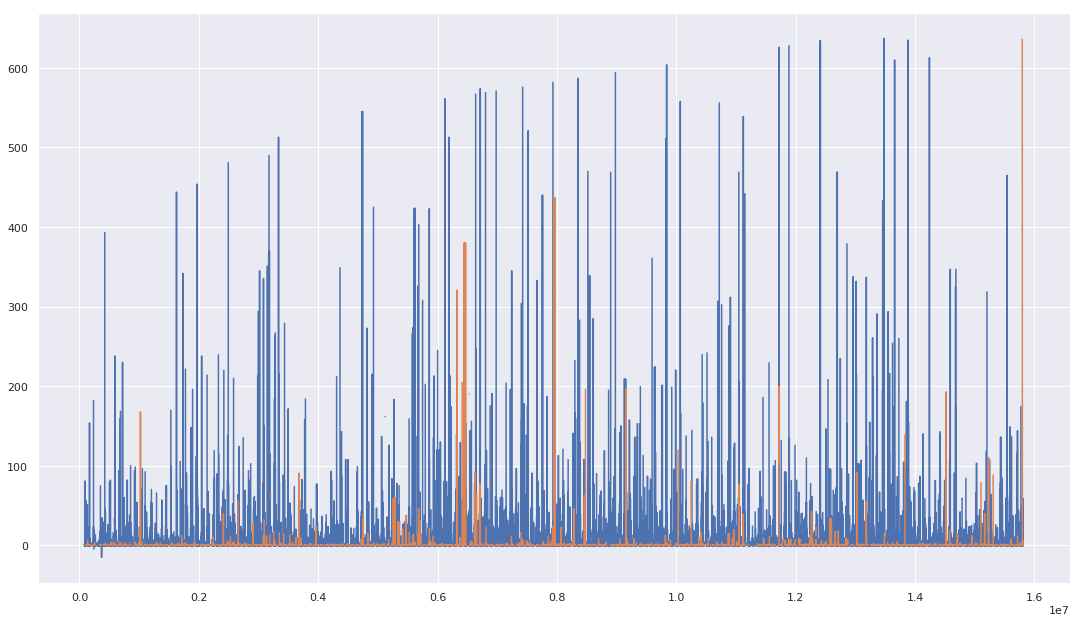

In [79]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].D1/
       train[train.isFraud == 0].D15)
ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].D1/
       train[train.isFraud == 1].D15)
plt.show()

In [8]:
df_imp.feature[:10]

0    TransactionAmt
1             card1
2               C13
3                N1
4                C1
5             card2
6             addr1
7                N3
8               D15
9               C14
Name: feature, dtype: object

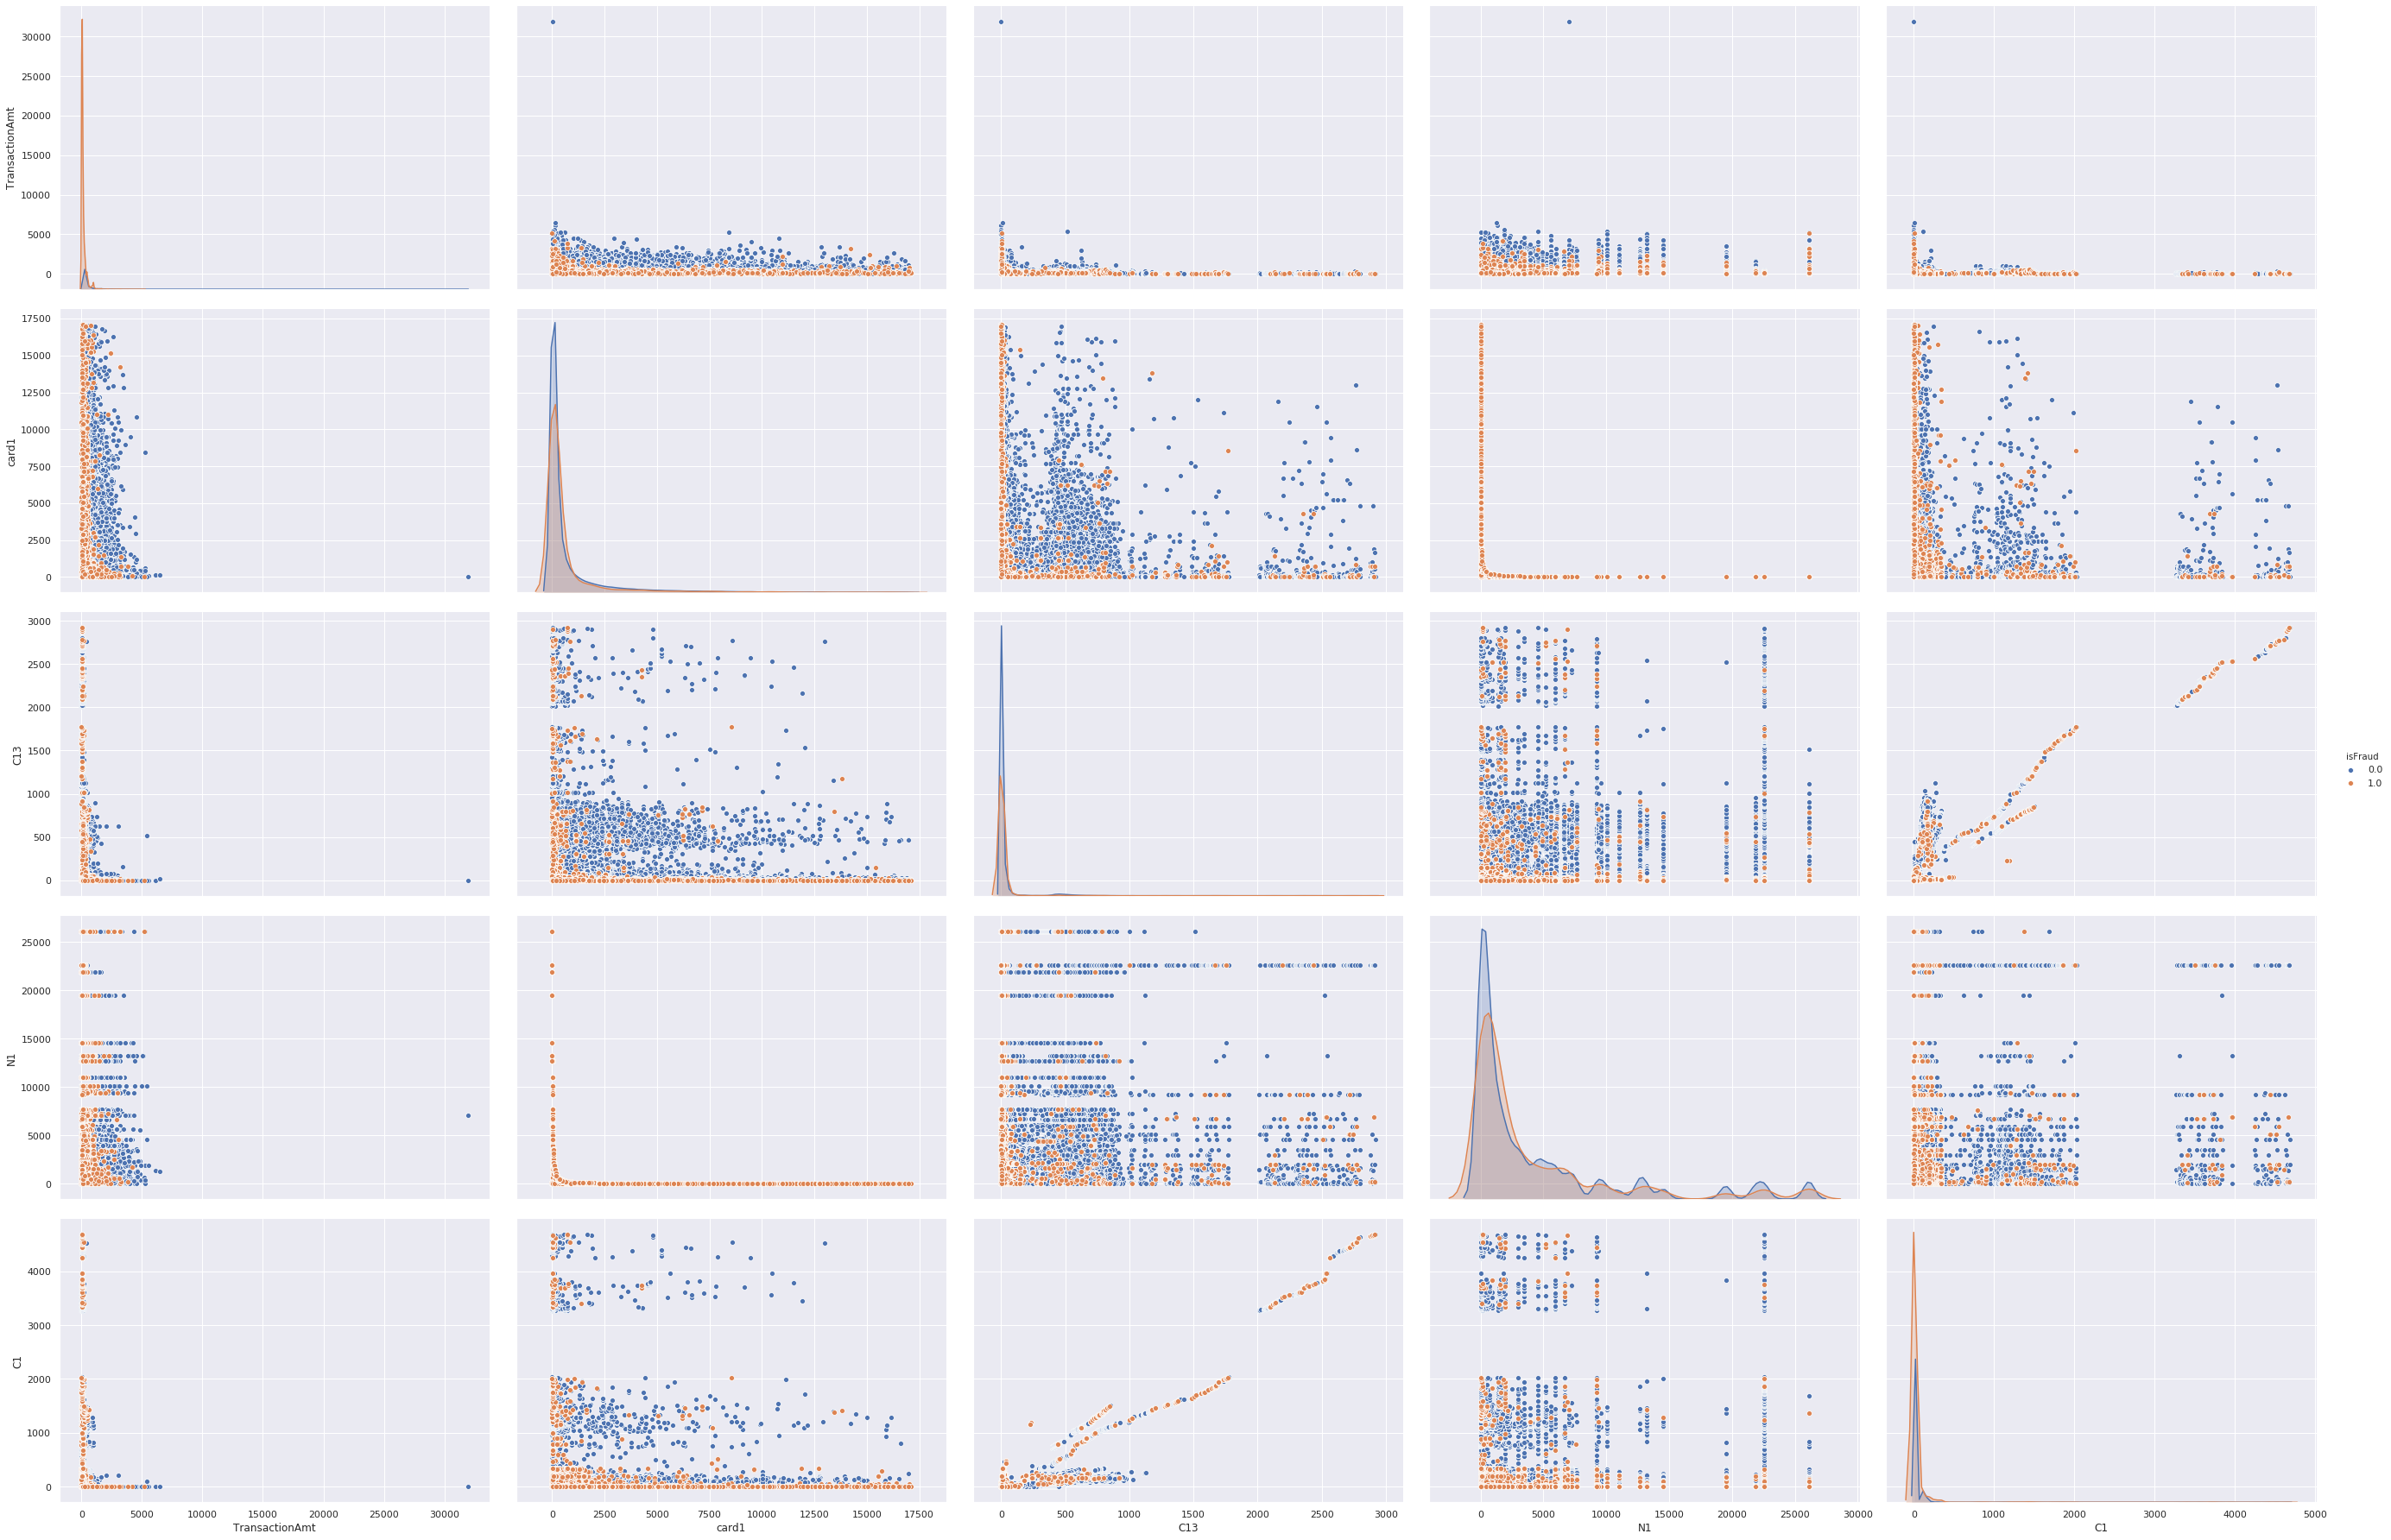

In [14]:
sns.pairplot(train.fillna(train.median()), hue='isFraud', vars=df_imp.feature[:5], height=5, aspect=1.5, dropna=True)

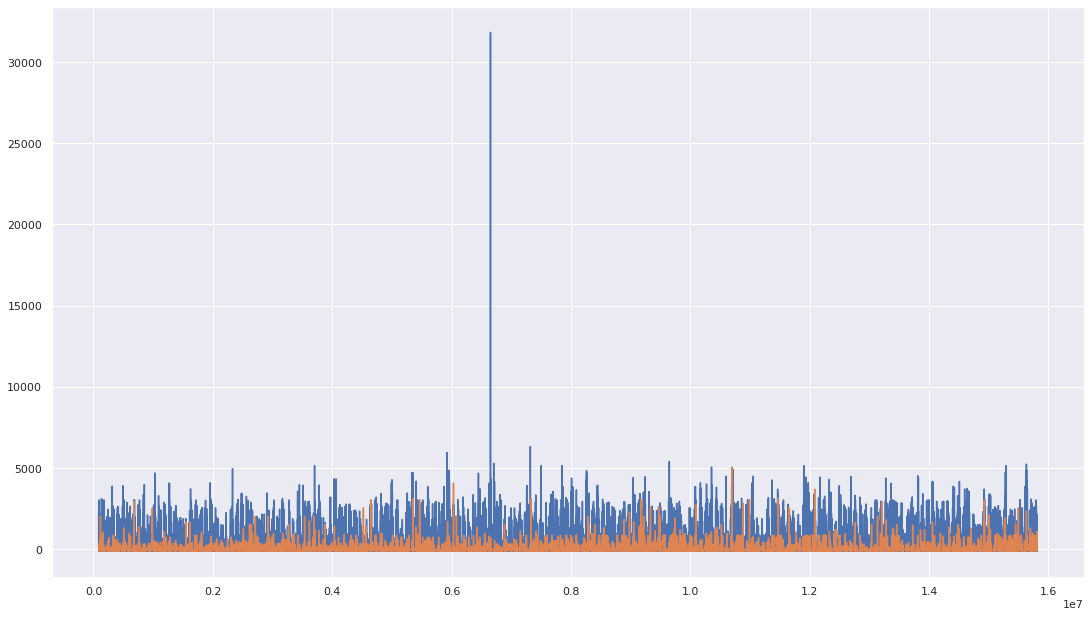

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].TransactionAmt - train.TransactionAmt.values.mean())
ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].TransactionAmt - train.TransactionAmt.values.mean())
plt.show()

In [24]:
train.columns.tolist()

['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D8',
 'D9',
 'DeviceInfo',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'P_emaildomain',
 'ProductCD',
 'R_emaildomain',
 'TransactionAmt',
 'TransactionDT',
 'V10',
 'V102',
 'V103',
 'V12',
 'V124',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V136',
 'V149',
 'V154',
 'V156',
 'V178',
 'V186',
 'V187',
 'V188',
 'V189',
 'V19',
 'V190',
 'V199',
 'V20',
 'V200',
 'V201',
 'V203',
 'V204',
 'V212',
 'V213',
 'V229',
 'V232',
 'V233',
 'V242',
 'V243',
 'V244',
 'V245',
 'V246',
 'V257',
 'V258',
 'V259',
 'V261',
 'V264',
 'V265',
 'V266',
 'V267',
 'V273',
 'V274',
 'V275',
 'V279',
 'V280',
 'V281',
 'V282',
 'V283',
 'V285',
 'V287',
 'V289',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V298',
 'V306',
 'V307',
 'V308',
 'V309',

In [26]:
train.Transaction_day_of_week.head(2)

0    0.0
1    0.0
Name: Transaction_day_of_week, dtype: float64

In [27]:
train.Transaction_day_of_week.tail(2)

590538    6.0
590539    6.0
Name: Transaction_day_of_week, dtype: float64

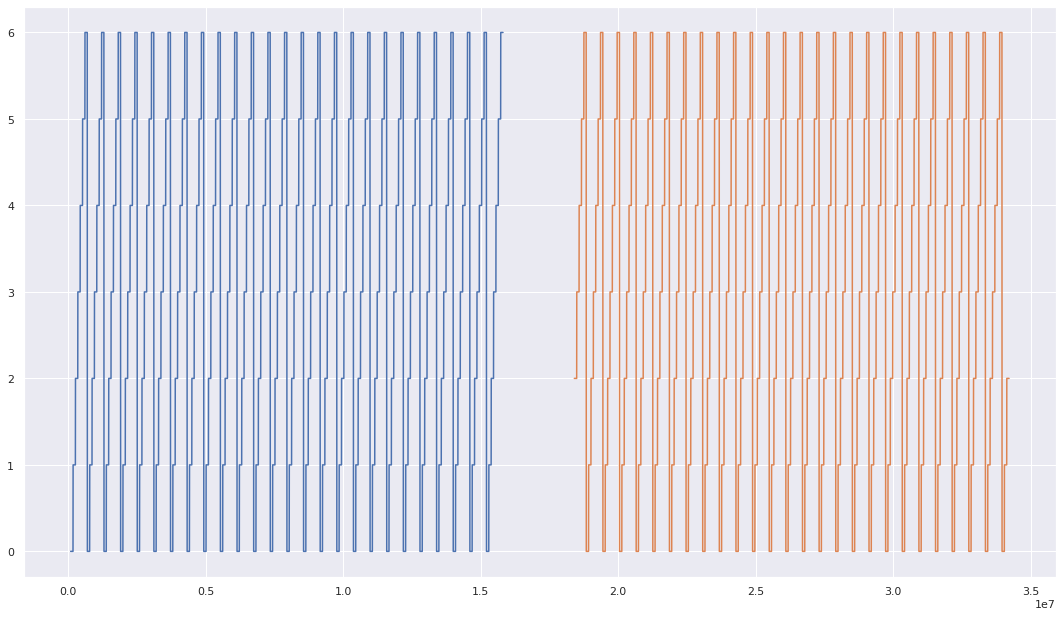

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train.TransactionDT, train.Transaction_day_of_week)
ax.plot(test.TransactionDT, test.Transaction_day_of_week)
plt.show()

In [34]:
num_cols = list()

for c in X_cols:
    if c not in cat_ft:
        num_cols.append(c)

In [42]:
num_cols[:15]

['TransactionAmt',
 'C13',
 'N1',
 'C1',
 'N3',
 'D15',
 'C14',
 'Transaction_hour',
 'C11',
 'N2',
 'D1',
 'group_2_n_64',
 'C6',
 'dist1',
 'D2']

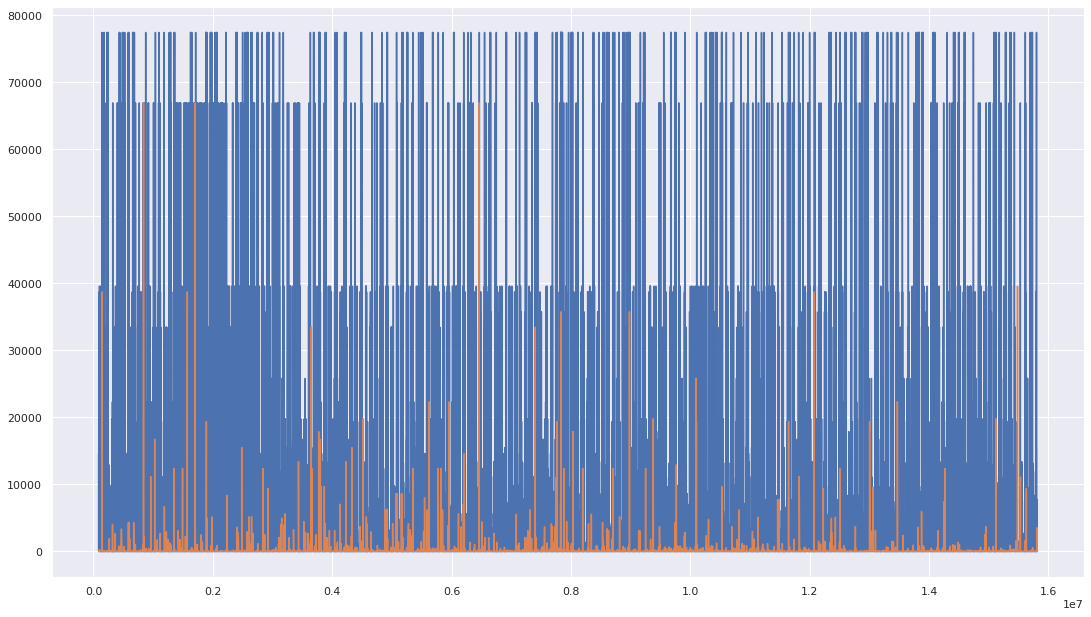

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].N3/train[train.isFraud == 0].N1)
ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].N3/train[train.isFraud == 1].N1)
plt.show()

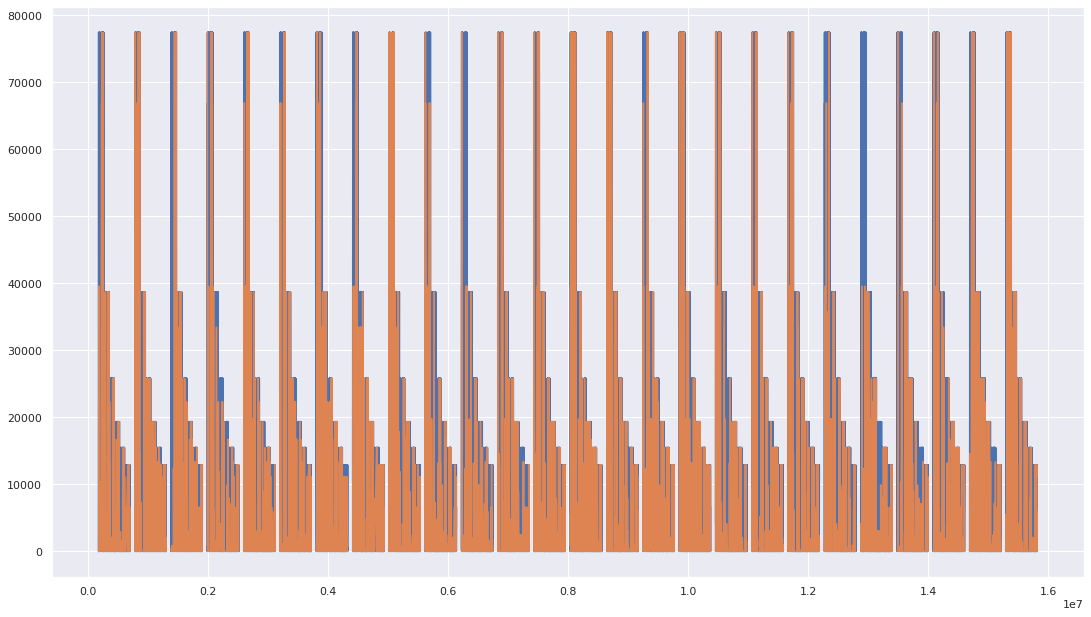

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].N3/train[train.isFraud == 0].Transaction_day_of_week)
ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].N3/train[train.isFraud == 1].Transaction_day_of_week)
plt.show()

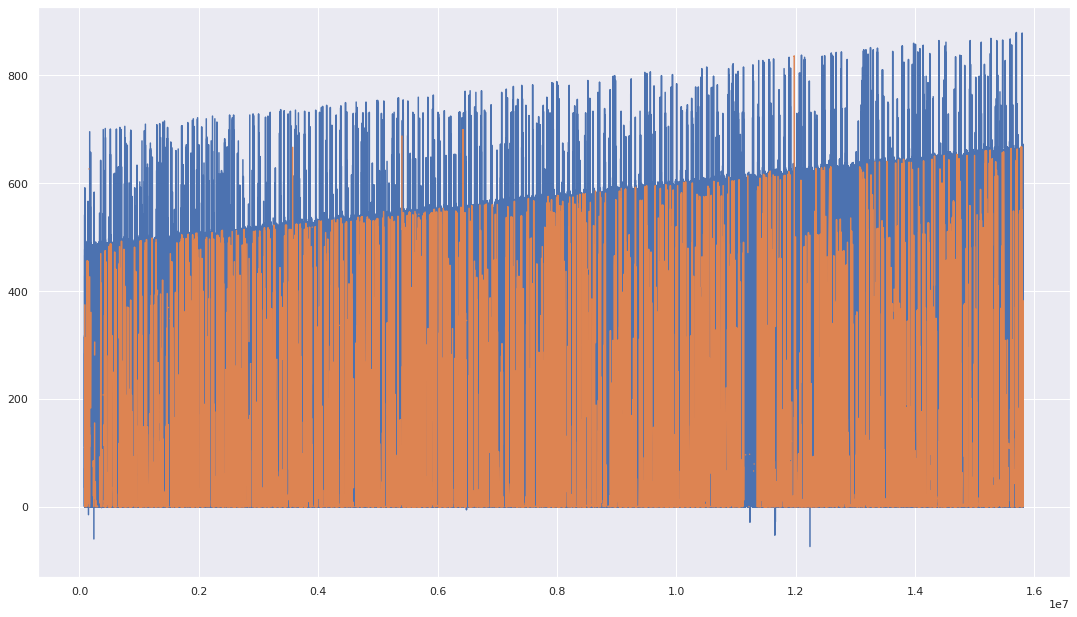

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].D15)
ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].D15)
plt.show()

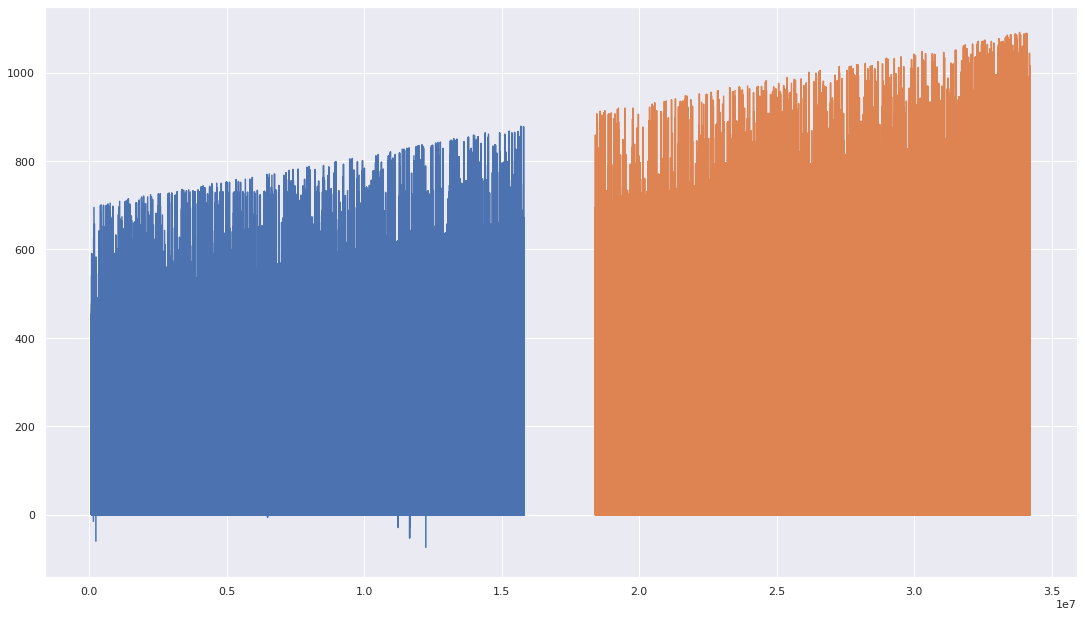

In [48]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train.TransactionDT, train.D15)
ax.plot(test.TransactionDT, test.D15)
plt.show()

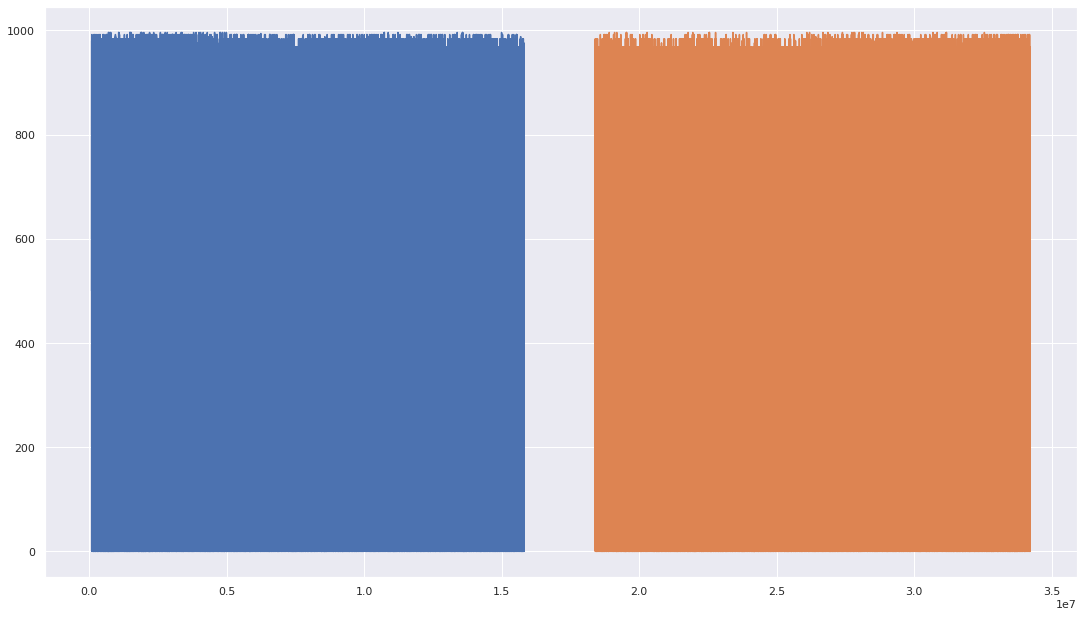

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train.TransactionDT, ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int))
ax.plot(test.TransactionDT, ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int))
plt.show()

In [51]:
((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)

0         500
1           0
2           0
3           0
4           0
         ... 
590535      0
590536    500
590537    953
590538      0
590539      0
Name: TransactionAmt, Length: 590540, dtype: int64

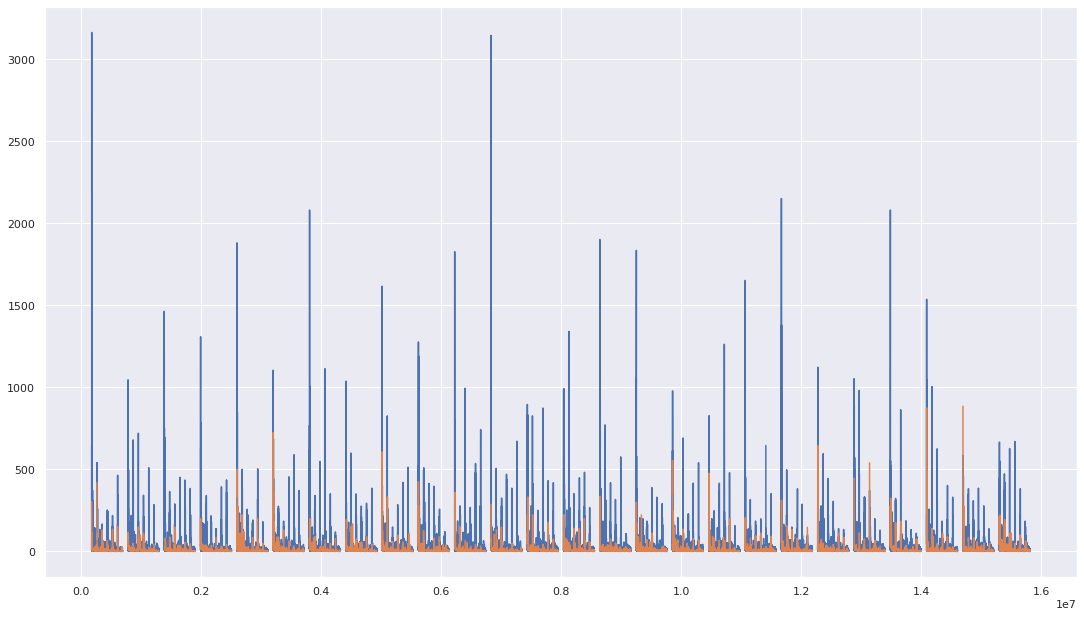

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].TransactionAmt / train[train.isFraud == 0].Transaction_hour / train[train.isFraud == 0].Transaction_day_of_week)
ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].TransactionAmt / train[train.isFraud == 1].Transaction_hour / train[train.isFraud == 1].Transaction_day_of_week)
plt.show()

In [107]:
def plot_new():
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 7)
    ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].new)
    ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].new)
    plt.show()
    gc.collect()

In [109]:
train['new'] = train['TransactionAmt'] / train.groupby(['card1', 'addr1'])['TransactionAmt'].transform('std')

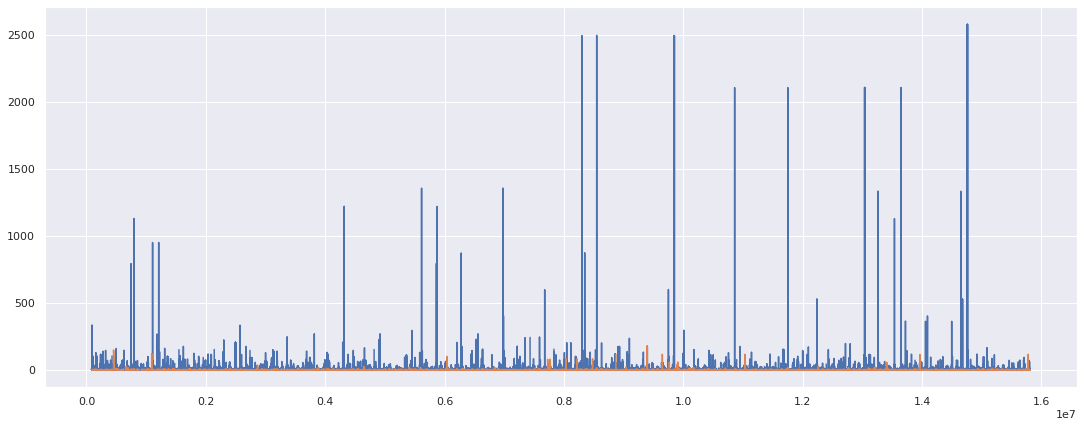

In [110]:
plot_new()

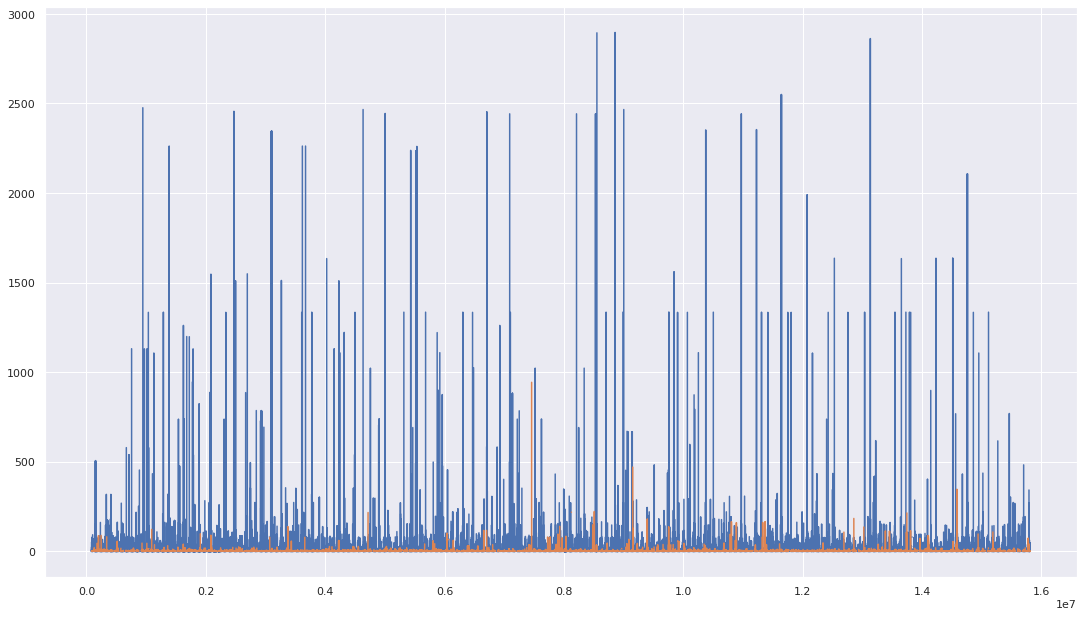

In [70]:
train['new'] = train['TransactionAmt'] / train.groupby(['card1','C13','C1','card2','addr1'])['TransactionAmt'].transform('std')
plot_new()

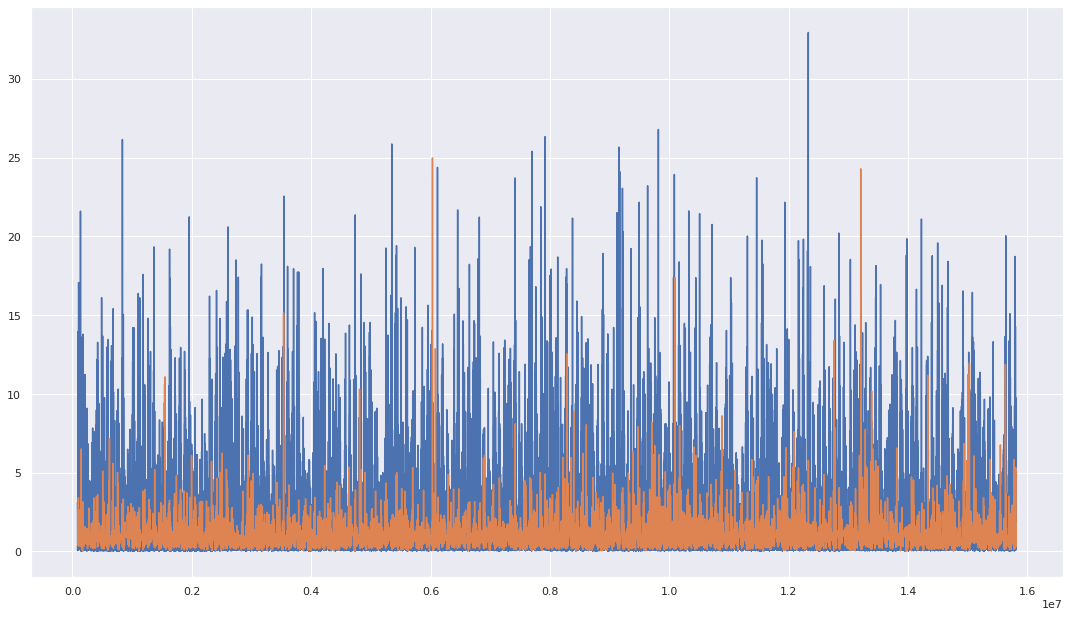

In [71]:
train['new'] = train['TransactionAmt'] / train.groupby(['card1','C13','C1','card2','addr1'])['TransactionAmt'].transform('mean')
plot_new()

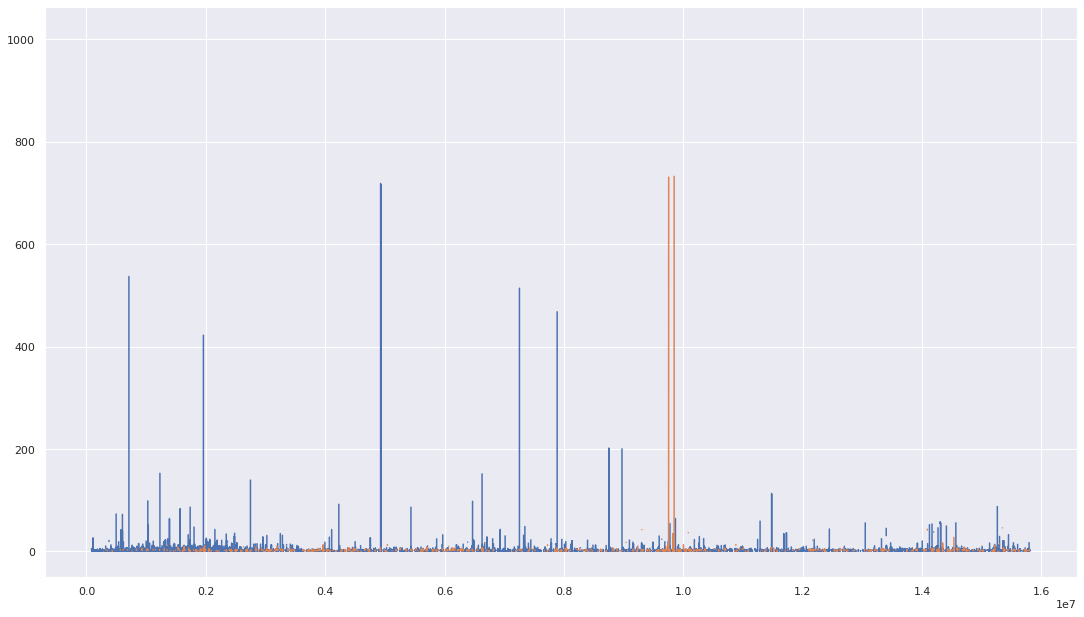

In [78]:
train['new'] = train['TransactionAmt'] / train.groupby(['card1','C1','addr1','id_01','V258','D1'])['TransactionAmt'].transform('std')
plot_new()

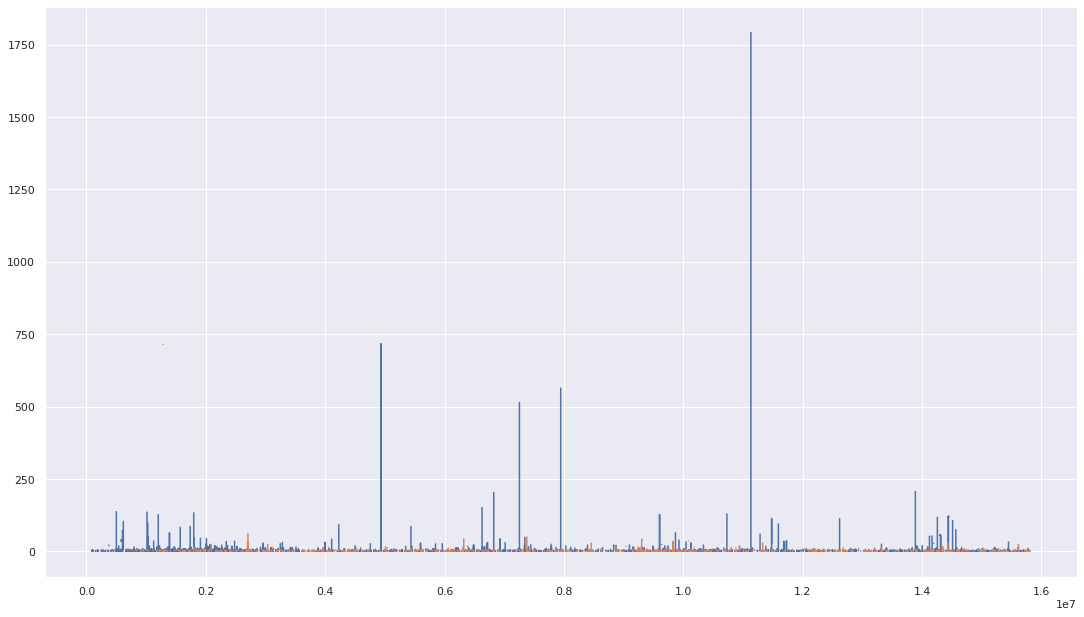

In [88]:
train['new'] = train['TransactionAmt'] / train.groupby(['card1','addr1','id_01','V258','D1', 'P_emaildomain', 'R_emaildomain'])['TransactionAmt'].transform('std')
plot_new()

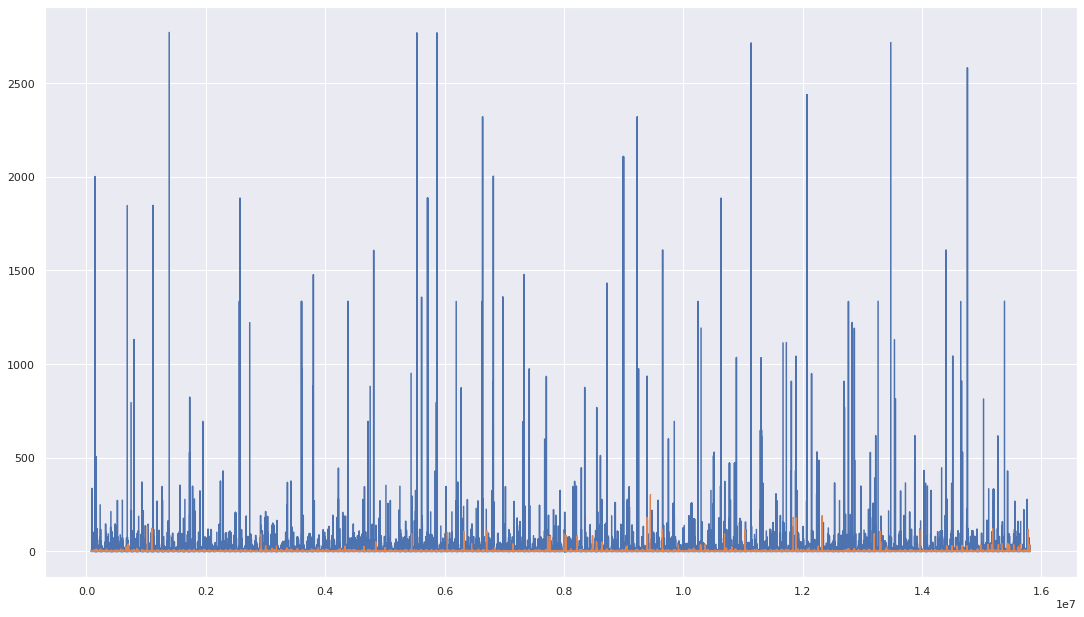

In [94]:
train['new'] = train['TransactionAmt'] / train.groupby(['card1','addr1','P_emaildomain', 'R_emaildomain'])['TransactionAmt'].transform('std')
plot_new()

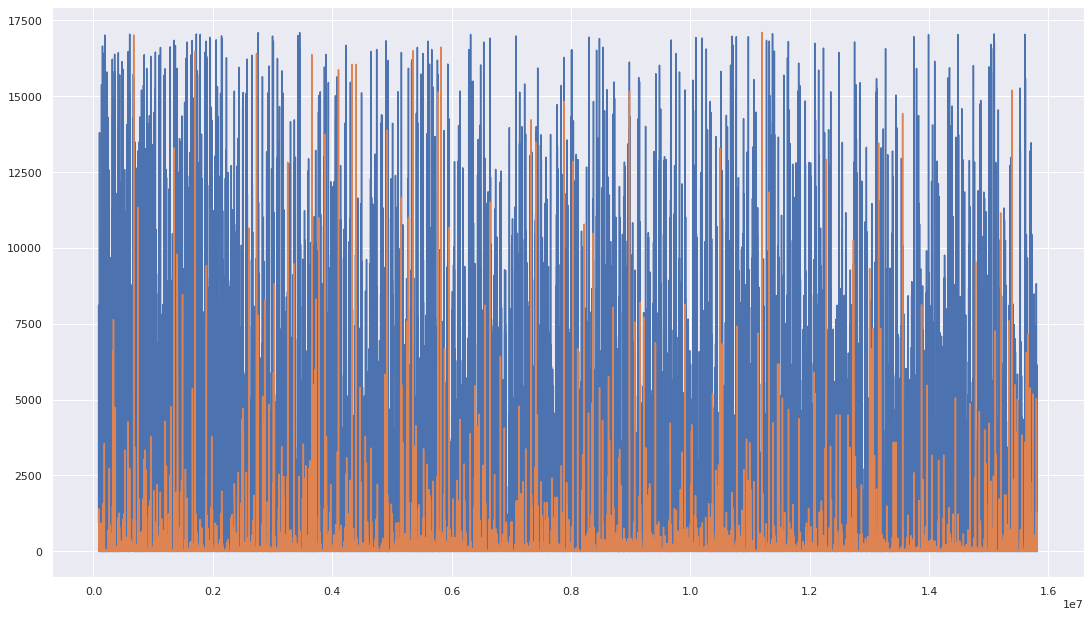

In [103]:
train['new'] = train['card1'] / train.groupby(['TransactionAmt','addr1','P_emaildomain', 'R_emaildomain'])['card1'].transform('count')
plot_new()

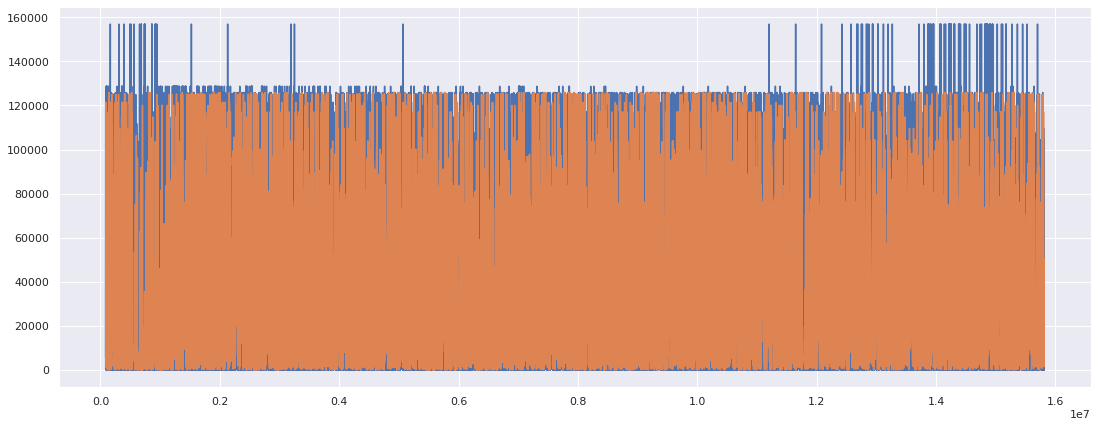

In [115]:
train['new'] = train.groupby(['card1','addr1'])['card1'].transform('mean')*train.groupby(['card1','addr1'])['card1'].transform('count')
plot_new()

In [26]:
X_cols

['TransactionAmt',
 'card1',
 'C13',
 'N1',
 'C1',
 'card2',
 'addr1',
 'N3',
 'D15',
 'C14',
 'Transaction_hour',
 'C11',
 'card1_fe1',
 'addr1_fe1',
 'N2',
 'D1',
 'card2_fe1',
 'group_2_n_64',
 'C6',
 'dist1',
 'D2',
 'D4',
 'Transaction_day_of_week',
 'addr1_fe2',
 'C2',
 'D10',
 'V258',
 'N4',
 'group_2_n_32',
 'card2_fe2',
 'P_emaildomain',
 'V307',
 'id_02',
 'card5',
 'card1_fe2',
 'DeviceInfo',
 'P_emaildomain_0',
 'V45',
 'V310',
 'C12',
 'P_emaildomain_fe2',
 'D11',
 'M5',
 'D3',
 'V317',
 'M6',
 'C9',
 'D8',
 'V308',
 'V201',
 'group_2_n_16',
 'card6',
 'id_19',
 'P_emaildomain_0_fe1',
 'card5_fe1',
 'V313',
 'id_31',
 'P_emaildomain_0_fe2',
 'V257',
 'C4',
 'D5',
 'C7',
 'V200',
 'V283',
 'M6_fe2',
 'C8',
 'id_20',
 'card5_fe2',
 'P_emaildomain_fe1',
 'C10',
 'V87',
 'V281',
 'V243',
 'V312',
 'V294',
 'V189',
 'V246',
 'M4',
 'M5_fe1',
 'V187',
 'V315',
 'V314',
 'V244',
 'V44',
 'V127',
 'card6_fe1',
 'id_01',
 'id_13',
 'group_1_n_64',
 'V54',
 'V53',
 'V62',
 'R_emaild

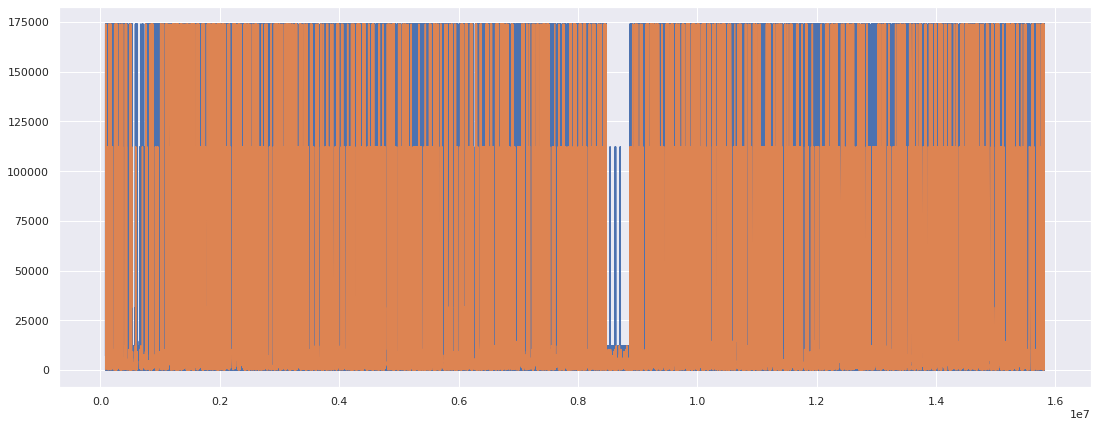

In [131]:
train['new'] = train.groupby(['P_emaildomain', 'addr1'])['R_emaildomain'].transform('count')/train.groupby(['P_emaildomain', 'addr1'])['R_emaildomain'].transform('std')
plot_new()

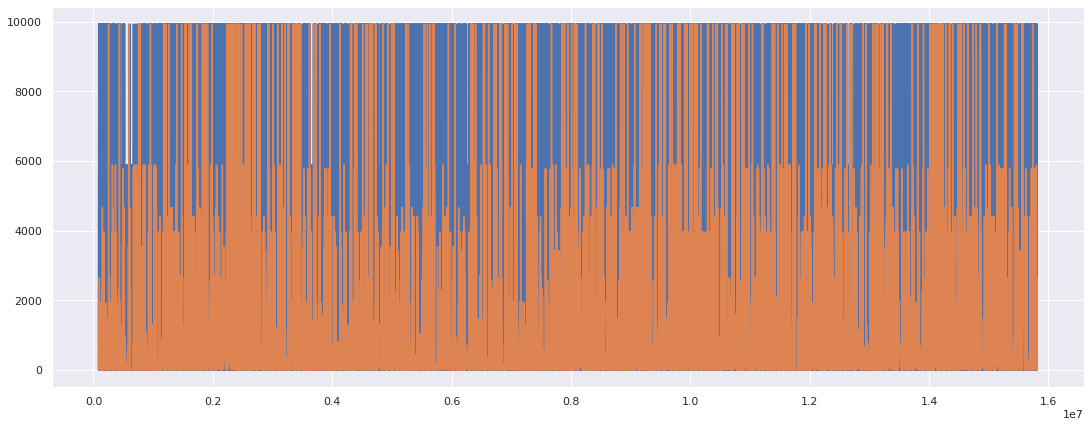

In [139]:
train['new'] = train.groupby(['card1', 'addr1']).transform('count')['TransactionDT']
plot_new()

In [8]:
test['isFraud'] = np.nan
train_index = train.shape[0]
test_index = test.shape[0]
df = pd.concat([train, test], axis=0)
df.shape

/home/errodringer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


(1097231, 77)

In [9]:
del train
del test
gc.collect()

21

In [10]:
cat_ft_sel = list()
for c in df.columns:
    if c in cat_ft:
        cat_ft_sel.append(c)
cat_ft_sel[:4]

['DeviceInfo', 'M5', 'M6', 'M6_fe2']

In [11]:
def del_col_same_value(df):
    new_sel_cols = list()
    for c in df.columns:
        if len(df[c].unique()) > 1:
            new_sel_cols.append(c)
    return df[new_sel_cols]
    

def from_df_to_sparse(df):
    
    df_dummies = csr_matrix(pd.DataFrame())
    
    for c in X_cols:
        if c in cat_ft_sel and c not in ['isFraud', 'TransactionDT']:
            if len(df[c].unique()) > 1000:
                dums = csr_matrix(del_col_same_value(pd.get_dummies(pd.cut(df[c], 256), prefix=c, dummy_na=False)))
                df_dummies = hstack([df_dummies, dums])
            else:
                dums = csr_matrix(del_col_same_value(pd.get_dummies(df[c], prefix=c, dummy_na=False)))
                df_dummies = hstack([df_dummies, dums])
        elif c not in cat_ft_sel + ['isFraud', 'TransactionDT']:
            if df[c].isna().sum() == 0:
                dums = csr_matrix(pd.get_dummies(pd.cut(df[c], 256), prefix=c, dummy_na=False))
                df_dummies = hstack([df_dummies, dums])
            else:
                dums = csr_matrix(del_col_same_value(pd.get_dummies(pd.cut(df[c], 256), prefix=c, dummy_na=True)))
                df_dummies = hstack([df_dummies, dums])
        else:
            pass
            
    return df_dummies

In [12]:
df_final = from_df_to_sparse(df)
df_final.shape

(1097231, 13045)

In [13]:
#Transform data using small groups to reduce memory usage
# m = 50000
# train_sparse = vstack([csr_matrix(train[X_cols].iloc[i*m:(i+1)*m,:]) for i in range(train.shape[0] // m + 1)])
print('Saving train data...')
save_npz(data_folder+'/train.npz', df_final.tocsr()[:train_index], compressed=True)
print('Saving test data...')
save_npz(data_folder+'/test.npz',  df_final.tocsr()[train_index:],  compressed=True)
print('Completed!')

Saving train data...
Saving test data...
Completed!


In [78]:
train_sparse.shape

(590540, 243)